In [72]:
import cobra
from cobra.io import read_sbml_model
from pprint import pprint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from process_bigraph import Composite
from process_bigraph import ProcessTypes
from process_bigraph.emitter import gather_emitter_results

from cdFBA import register_types
from cdFBA.processes.dfba import dFBA, UpdateEnvironment, StaticConcentration, Injector, WaveFunction

from cdFBA.utils import make_cdfba_composite, get_injector_spec, get_wave_spec, get_static_spec, set_concentration, set_kinetics

In [73]:
# Goal: Replicate Adrian et al. model quantitatively using cdFBA

# 3 bacteria species
# /Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Bacteroides_thetaiotaomicron_VPI_5482.xml
# /Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Methanobrevibacter_smithii_ATCC_35061.xml
# /Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Eubacterium_rectale_ATCC_33656.xml

In [74]:
b_thetaiotaomicron = cobra.io.read_sbml_model("/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Bacteroides_thetaiotaomicron_VPI_5482.xml")
b_thetaiotaomicron.optimize()
b_thetaiotaomicron.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
2obut[e],EX_2obut(e),1000,4,5.13%
C02528[e],EX_C02528(e),762.9,24,23.50%
acgam[e],EX_acgam(e),10.43,8,0.11%
adn[e],EX_adn(e),13.43,10,0.17%
arg_L[e],EX_arg_L(e),25.73,6,0.20%
asn_L[e],EX_asn_L(e),20.95,4,0.11%
ca2[e],EX_ca2(e),0.323,0,0.00%
cholate[e],EX_cholate(e),1000,24,30.80%
cit[e],EX_cit(e),0.646,6,0.00%
cl[e],EX_cl(e),0.323,0,0.00%


In [75]:
e_rectale = cobra.io.read_sbml_model("/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Eubacterium_rectale_ATCC_33656.xml")
e_rectale.optimize()
e_rectale.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
12dgr180[e],EX_12dgr180(e),2.35,39,0.48%
acald[e],EX_acald(e),1000,2,10.55%
asn_L[e],EX_asn_L(e),8.384,4,0.18%
asp_L[e],EX_asp_L(e),135.2,4,2.85%
ca2[e],EX_ca2(e),0.4488,0,0.00%
cl[e],EX_cl(e),0.4488,0,0.00%
cobalt2[e],EX_cobalt2(e),0.4488,0,0.00%
cu2[e],EX_cu2(e),0.4488,0,0.00%
cys_L[e],EX_cys_L(e),4.566,3,0.07%
fe2[e],EX_fe2(e),1.346,0,0.00%


In [76]:
m_simithii = cobra.io.read_sbml_model("/Users/rebekahsheih/PycharmProjects/Rebekahs_Rotation_Project/Vivarium/cdFBA-main/Notebooks/sbml/Methanobrevibacter_smithii_ATCC_35061.xml")
m_simithii.optimize()
m_simithii.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
12dhchol[e],EX_12dhchol(e),415.6,24,29.68%
acald[e],EX_acald(e),1000,2,5.95%
ala_D[e],EX_ala_D(e),6.071,3,0.05%
ala_L[e],EX_ala_L(e),16.41,3,0.15%
alahis[e],EX_alahis(e),3.04,9,0.08%
asn_L[e],EX_asn_L(e),7.703,4,0.09%
asp_L[e],EX_asp_L(e),121.5,4,1.45%
ca2[e],EX_ca2(e),0.1901,0,0.00%
chor[e],EX_chor(e),828.3,10,24.65%
cl[e],EX_cl(e),0.1901,0,0.00%


In [77]:
# interested in following exchange reactions: acetate, butyrate, CO2, H2, CH4, and a polysaccharide

In [78]:
gut_models = {
        "B_thetaiotaomicron": "Bacteroides_thetaiotaomicron_VPI_5482.xml",
        "E_rectale": "Eubacterium_rectale_ATCC_33656.xml",
        "Methanobrevibacter_smithii": "Methanobrevibacter_smithii_ATCC_35061.xml"
    }

exchanges = ['EX_ac(e)', 'EX_but(e)', 'EX_co2(e)', 'EX_h(e)', 'EX_ch4(e)', 'EX_cholate(e)'] # acetate, butyrate, CO2, H2, methane, exopolysaccharide

volume = 2

# dFBA model
spec = make_cdfba_composite(gut_models, medium_type=None, exchanges=exchanges, volume=volume, interval=0.1)

pprint(spec)

{'Shared Environment': {'concentrations': {'B_thetaiotaomicron': 0.25,
                                           'Cholate': 10.0,
                                           'E_rectale': 0.25,
                                           'Methane': 10.0,
                                           'Methanobrevibacter_smithii': 0.25,
                                           'acetate': 10.0,
                                           'butyrate': 10.0,
                                           'carbon dioxide': 10.0,
                                           'proton': 10.0},
                        'counts': {'B_thetaiotaomicron': 0.5,
                                   'Cholate': 20,
                                   'E_rectale': 0.5,
                                   'Methane': 20,
                                   'Methanobrevibacter_smithii': 0.5,
                                   'acetate': 20,
                                   'butyrate': 20,
                                  

In [79]:
#Set reaction bounds
spec['Species']['B_thetaiotaomicron']['config']['bounds'] = {
            "EX_o2(e)": {"lower": -2, "upper": None},
            "dreplication": {"lower": 1, "upper": 1},
            'EX_glu_L(e)': {"lower":0, "higher": 0}
        }
spec['Species']['E_rectale']['config']['bounds'] = {
            "EX_o2(e)": {"lower": -2, "upper": None},
            "dreplication": {"lower": 1, "upper": 1},
            'EX_glu_L(e)': {"lower":0, "higher": 0}
        }
spec['Species']['Methanobrevibacter_smithii']['config']['bounds'] = {
            "EX_o2(e)": {"lower": -2, "upper": None},
            "dreplication": {"lower": 1, "upper": 1},
            'EX_glu_L(e)': {"lower":0, "higher": 0}
        }

In [80]:
#set external substrate concentrations
concentrations = {      # abundance of exopolysaccharide, limit acetate so that it has to come from keystone species
    'acetate': 0,
    'Cholate': 5,
    'butyrate': 0,
    'Methane': 0
}
set_concentration(spec, concentrations)

In [81]:
#set kinetics
kinetics = {
    'acetate': (0.5, 5),
    'Cholate': (0.5, 5),
    'butyrate': (0.5, 5),
    'Methane': (0.5, 5),
}
for species in gut_models.keys():
    set_kinetics(species, spec, kinetics)
pprint(spec)

{'Shared Environment': {'concentrations': {'B_thetaiotaomicron': 0.25,
                                           'Cholate': 5,
                                           'E_rectale': 0.25,
                                           'Methane': 0,
                                           'Methanobrevibacter_smithii': 0.25,
                                           'acetate': 0,
                                           'butyrate': 0,
                                           'carbon dioxide': 10.0,
                                           'proton': 10.0},
                        'counts': {'B_thetaiotaomicron': 0.5,
                                   'Cholate': 10,
                                   'E_rectale': 0.5,
                                   'Methane': 0,
                                   'Methanobrevibacter_smithii': 0.5,
                                   'acetate': 0,
                                   'butyrate': 0,
                                   'carbon dioxid

In [82]:
#set emitter specs
spec['emitter'] = {
        "_type": "step",
        "address": "local:ram-emitter",
        "config": {
            "emit": {
                "shared_environment": "any",
                "global_time": "any",
            }
        },
        "inputs": {
            "shared_environment": ["Shared Environment"],
            "global_time": ["global_time"]
        }
    }

In [83]:
#create the core object
core = ProcessTypes()
#register data types
core = register_types(core)
#register all processes and steps
core.register_process('dFBA', dFBA)
core.register_process('UpdateEnvironment', UpdateEnvironment)
core.register_process('StaticConcentration', StaticConcentration)
core.register_process('WaveFunction', WaveFunction)
core.register_process('Injector', Injector)

In [84]:
#create simulation composite
sim = Composite({
        "state": spec,
        },
        core=core
    )

In [85]:
#run simulation
sim.run(20)

In [86]:
#gather results
results = gather_emitter_results(sim)[('emitter',)]

In [87]:
#extract time-series data
timepoints = []
for timepoint in results:
    time = timepoint.pop('global_time')
    timepoints.append(time)
env = [timepoint['shared_environment']['concentrations'] for timepoint in results]
env_combined = {}
for d in env:
    for key, value in d.items():
        if key not in env_combined:
            env_combined[key] = []
        env_combined[key].append(value)

In [91]:
results

[{'shared_environment': {'concentrations': {'proton': 10.0,
    'Methane': 0.0,
    'Cholate': 5.0,
    'carbon dioxide': 10.0,
    'butyrate': 0.0,
    'acetate': 0.0,
    'B_thetaiotaomicron': 0.25,
    'E_rectale': 0.25,
    'Methanobrevibacter_smithii': 0.25},
   'counts': {'proton': 20.0,
    'Methane': 0.0,
    'Cholate': 10.0,
    'carbon dioxide': 20.0,
    'butyrate': 0.0,
    'acetate': 0.0,
    'B_thetaiotaomicron': 0.5,
    'E_rectale': 0.5,
    'Methanobrevibacter_smithii': 0.5},
   'volume': 2.0}},
 {'shared_environment': {'counts': {'proton': 20.0,
    'Methane': 0.0,
    'Cholate': 10.0,
    'carbon dioxide': 20.0,
    'butyrate': 0.0,
    'acetate': 0.0,
    'B_thetaiotaomicron': 0.5,
    'E_rectale': 0.5,
    'Methanobrevibacter_smithii': 0.5},
   'concentrations': {'proton': 10.0,
    'Methane': 0.0,
    'Cholate': 5.0,
    'carbon dioxide': 10.0,
    'butyrate': 0.0,
    'acetate': 0.0,
    'B_thetaiotaomicron': 0.25,
    'E_rectale': 0.25,
    'Methanobrevibacter_s

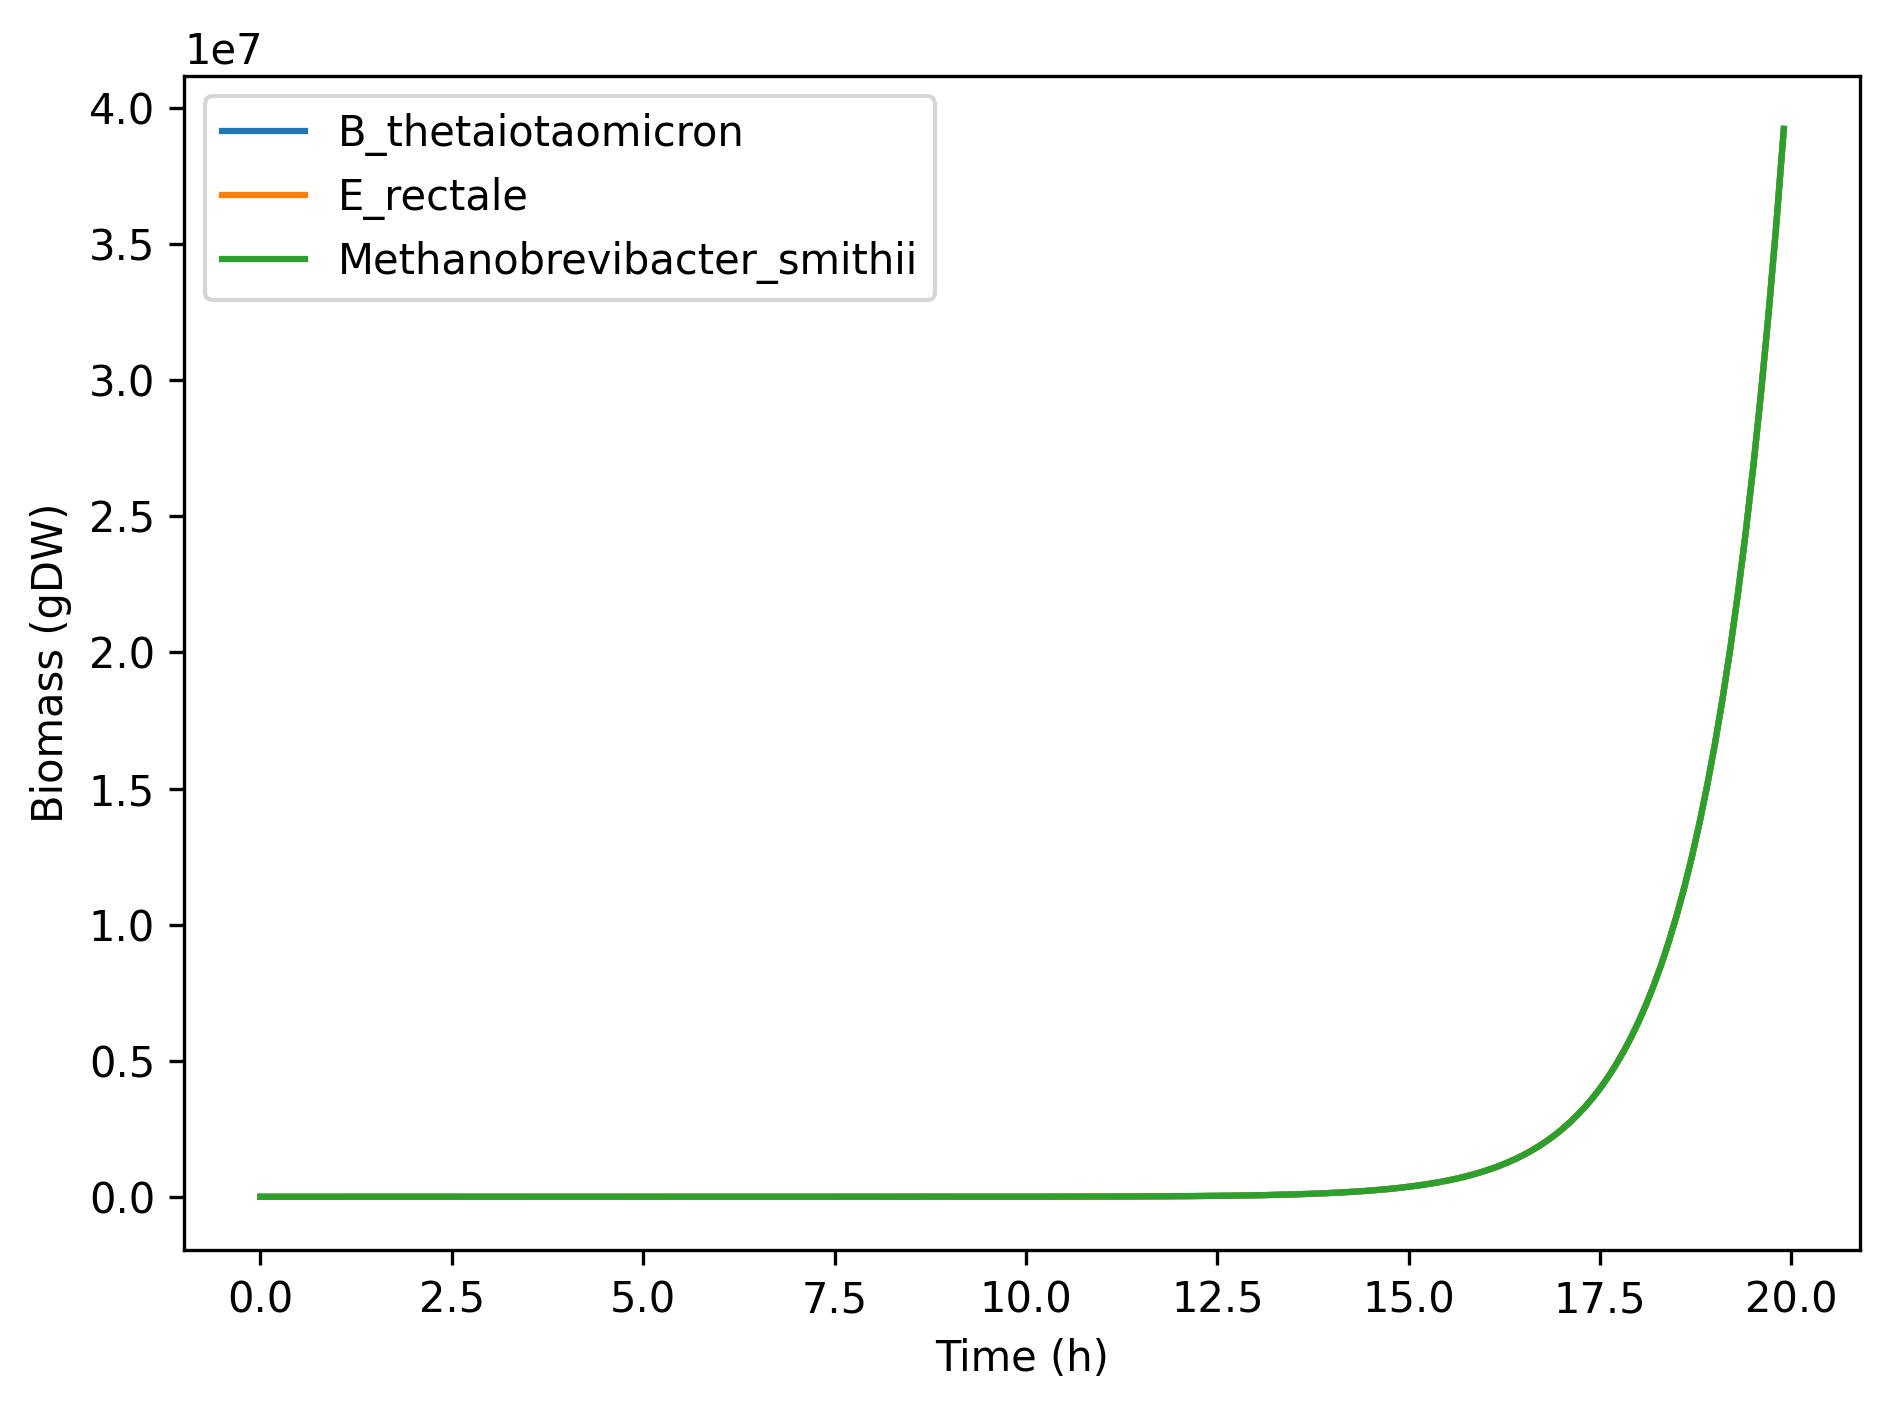

In [99]:
#plot results for biomass
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key not in ['acetate', 'Cholate', 'carbon dioxide', 'butyrate', 'Methane', 'proton']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time (h)')
plt.ylabel('Biomass (gDW)')
plt.legend()
plt.tight_layout()
plt.show()

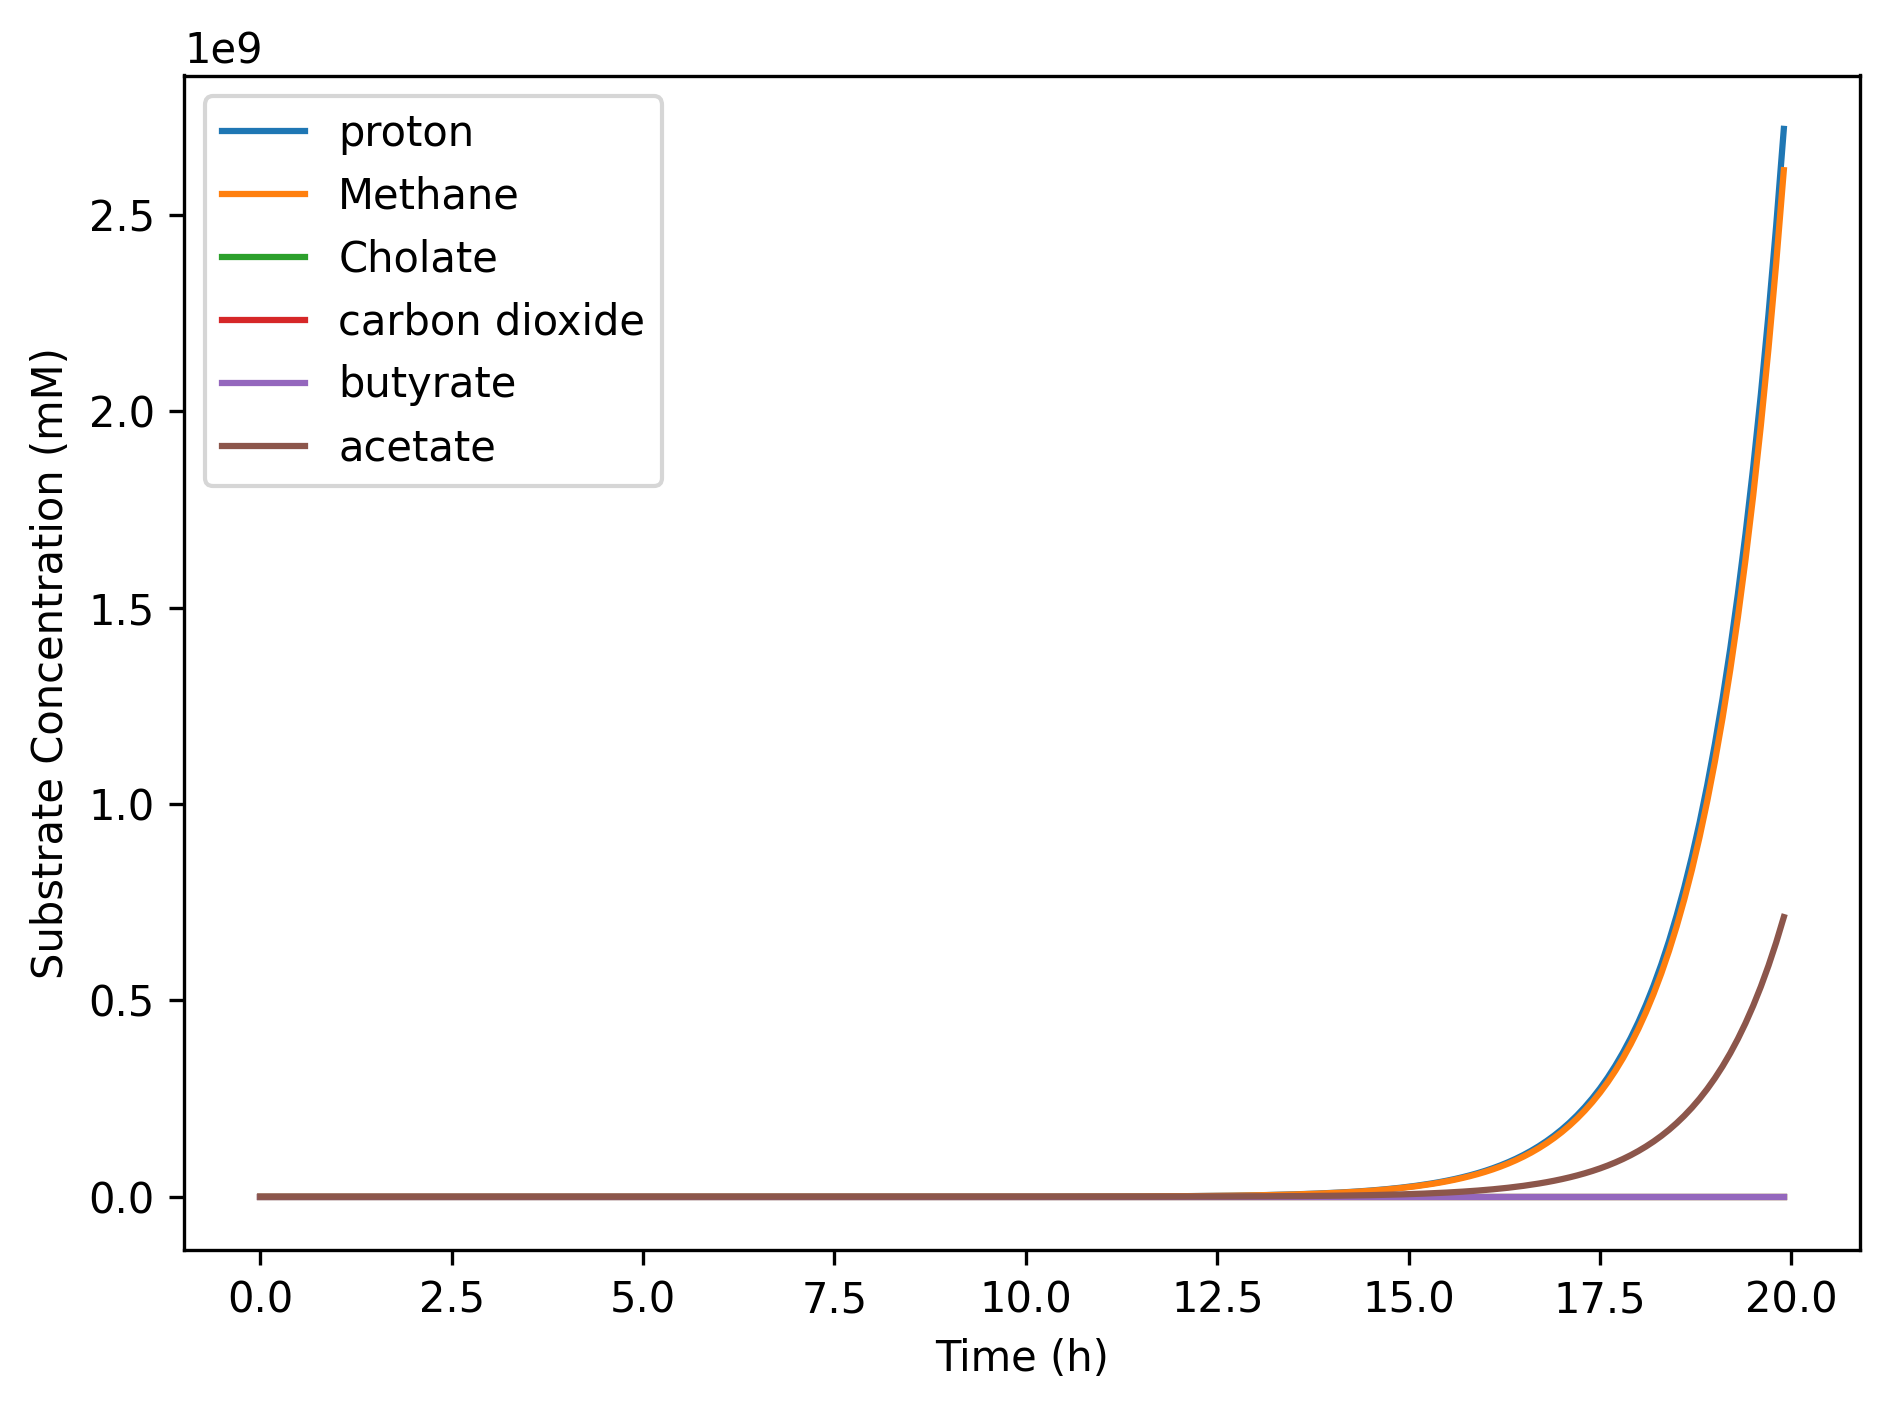

In [96]:
#plot substrates
fig, ax = plt.subplots(dpi=300)
for key, value in env_combined.items():
    if key in ['acetate', 'Cholate', 'carbon dioxide', 'butyrate', 'Methane', 'proton']:
        ax.plot(timepoints, env_combined[key], label=key)
plt.xlabel('Time (h)')
plt.ylabel('Substrate Concentration (mM)')
plt.legend()
plt.tight_layout()
plt.show()